## CarND-Vehicle-Detection
---
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
---

### Imports

In [1]:
# Import all the required libraries
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

### Load Training Data

In [2]:
car_image_names = glob.glob('training_data/vehicles/**/*.png')
noncar_image_names = glob.glob('training_data/non-vehicles/**/*.png')
print()
print("No of Car Image Samples:      {} samples".format(len(car_image_names)))
print("No of Non-Car Image Samples:  {} samples".format(len(noncar_image_names)))


No of Car Image Samples:      8792 samples
No of Non-Car Image Samples:  8968 samples


### Data Exploration

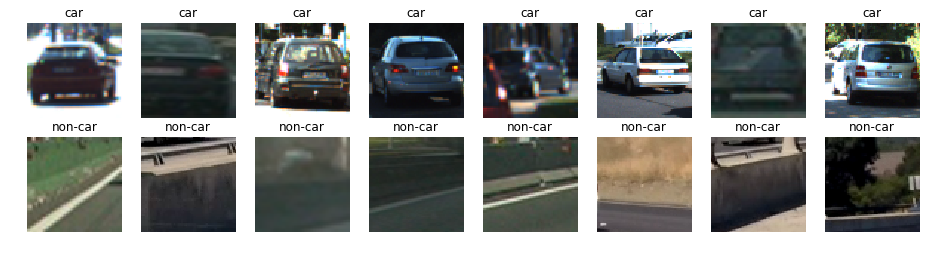

In [3]:
# Visualise car and non car images
fig, axes = plt.subplots(2,8, figsize=(16, 4))
fig.subplots_adjust(hspace = .1, wspace=.2)
axes = axes.ravel()

for i in np.arange(8):
    img = mpimg.imread(car_image_names[np.random.randint(0,len(car_image_names))])
    axes[i].axis('off')
    axes[i].set_title('car')
    axes[i].imshow(img)
    
for i in np.arange(8,16):
    img = mpimg.imread(noncar_image_names[np.random.randint(0,len(noncar_image_names))])
    axes[i].axis('off')
    axes[i].set_title('non-car')
    axes[i].imshow(img)

### Compute Image Features For Classification


#### Histogram of Oriented Gradients (HOG)


In [4]:
# Adapted from classroom quizzes
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

#### Color Histogram Features

In [5]:
# Adapted from classroom quizzes
# Define a function to compute color histogram features 
def color_hist(img, nbins=32):
    ch1 = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))[0]# We need only the histogram, no bins edges
    ch2 = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))[0]
    ch3 = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))[0]
    hist = np.hstack((ch1, ch2, ch3))
    return hist

#### Spatial Binning Of Color

In [6]:
# Adapted from classroom quizzes
# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    return cv2.resize(img, size).ravel()

#### Extract and visualise hog features of a random sample image


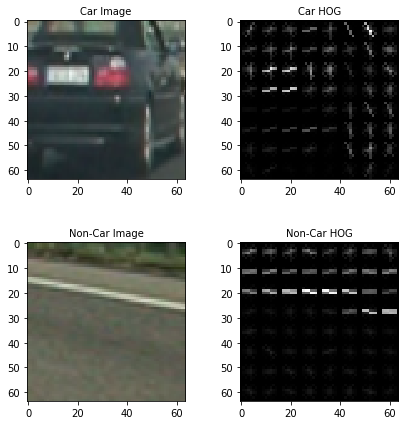

In [7]:
# Read images
car_image = mpimg.imread(car_image_names[np.random.randint(0,len(car_image_names))])
noncar_image = mpimg.imread(noncar_image_names[np.random.randint(0,len(noncar_image_names))])

#Convert to grayscale
car_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
noncar_gray = cv2.cvtColor(noncar_image, cv2.COLOR_RGB2GRAY)

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

#Get hog features                                             
features, car_hog_image = get_hog_features(car_gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
features, noncar_hog_image = get_hog_features(noncar_gray,  orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Visualize 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
fig.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_image)
ax1.set_title('Car Image', fontsize=10)
ax2.imshow(car_hog_image, cmap='gray')
ax2.set_title('Car HOG', fontsize=10)
ax3.imshow(noncar_image)
ax3.set_title('Non-Car Image', fontsize=10)
ax4.imshow(noncar_hog_image, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=10)

### Extract Features
This function extracts features from a list of images. It extracts hog, spatial and color histogram features and combines them into a single feature vector for classification   



In [8]:
# Adapted from course material
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32, 32),
                        hist_bins=32):
        # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Compute Spatial Color Bining Features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Compute Color Histogrm Features
        hist_features = color_hist(feature_image, nbins=hist_bins)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate([hog_features,spatial_features, hist_features]))
        #features.append(hog_features)
    # Return list of feature vectors
    return features

#### Explore feature extraction parameters 

In [9]:
# Feature extraction parameters
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size= (16,16)
hist_bins=16
t = time.time()
car_features = extract_features(car_image_names, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_size=spatial_size,hist_bins=hist_bins)
notcar_features = extract_features(noncar_image_names, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_size=spatial_size,hist_bins=hist_bins)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Fit a per-column scaler 
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

85.77 Seconds to extract features...
Using: 10 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6696


### Training a linear SVM classifier with extracted image features

In [10]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('SVC prediction: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

22.19 Seconds to train SVC...
Test Accuracy of SVC =  0.9837
SVC prediction:  [ 0.  1.  0.  1.  0.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  1.  1.  0.  1.]
0.00206 Seconds to predict 10 labels with SVC


### Detect cars in an image using trained classifier


In [11]:
# Adapted from lesson materials
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.concatenate([hog_features,spatial_features,hist_features]))       
            #test_features = X_scaler.transform(hog_features)       
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

### Test find_car on an Example Image

In [12]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 2.0
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10
pix_per_cell = 8
cell_per_block = 2
spatial_size=(16,16)
hist_bins=16

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size,hist_bins)

print(len(rectangles), 'rectangles found in image')

7 rectangles found in image


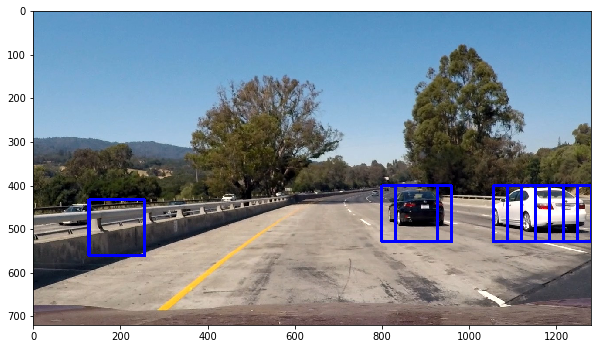

In [13]:
# Define a function to draw bounding boxes on an image
# Adapted from class materials
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

### Vehicle Detection with Multiple Scale Sliding Windows

Since the size and position of cars in the image will vary depending on their distance from the camera, exploring `find_cars` method with different `ystart`, `ystop`, and `scale` parameters to find the best possible combination to accomodate detection of cars of varying shape and sizes. 

Number of bounding boxes:  3


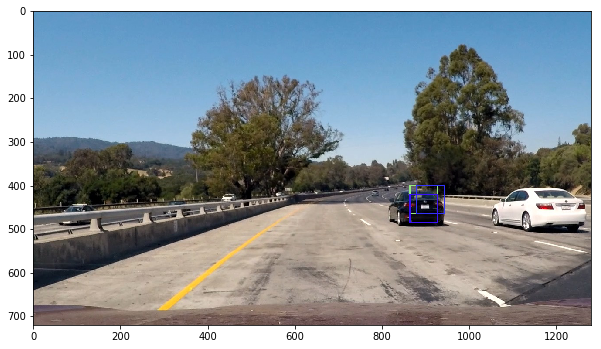

In [14]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 464
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size,hist_bins))

ystart = 420
ystop = 484
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size,hist_bins))


rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of bounding boxes: ', len(rectangles))

Number of bounding boxes:  11


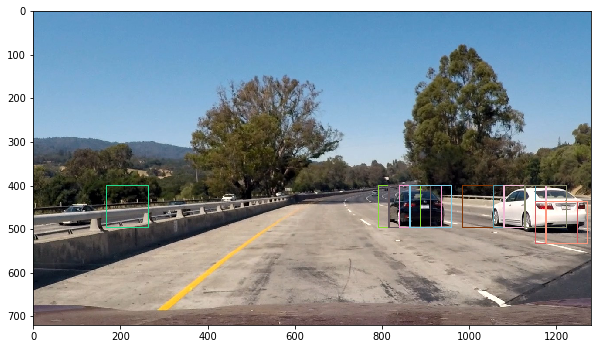

In [15]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []
ystart = 400
ystop = 496
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size,hist_bins))

ystart = 436
ystop = 532
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size,hist_bins))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of bounding boxes: ', len(rectangles))

Number of bounding boxes:  7


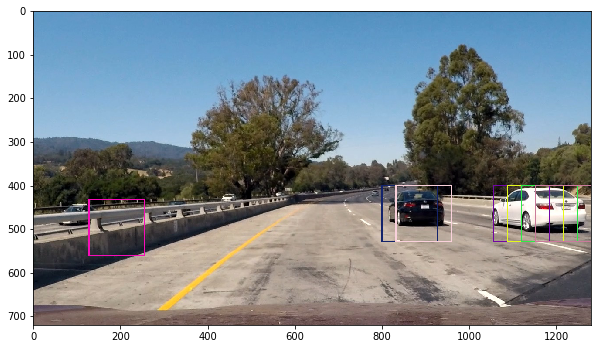

In [16]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []
ystart = 400
ystop = 528
scale = 2.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size,hist_bins))

ystart = 432
ystop = 560
scale = 2.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size,hist_bins))


rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of bounding boxes: ', len(rectangles))

### Aggregate vehicle detections at different scales

...


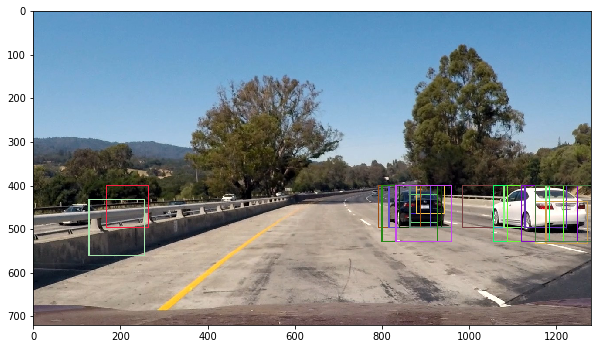

In [17]:
# Get detections for multiple sliding window parameters 
def combined_detection(img):
    rects = []
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 10
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size=(16, 16)
    hist_bins=16
    # Create a list of final sliding window parameters in [ystart, ystop, scale] format to combine detection results 
    sliding_windows = [[400,464,1.0],[420,484,1.0],[400,496,1.5],[436,532,1.5],[400,528,2.0],[432,560,2.0],[404,628,3.5],[464,688,3.5]]
    for sliding_window in sliding_windows:
        ystart = sliding_window[0]
        ystop = sliding_window[1]
        scale = sliding_window[2]
        rects.append(find_cars(img, ystart, ystop, scale, colorspace, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size,hist_bins))
    return rects

test_img = mpimg.imread('./test_images/test1.jpg')
detections = combined_detection(test_img)
rectangles = [item for sublist in detections for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('...')

## Filter False Positives Using Heatmap Thresholding

### Heatmap
This method produces a heat map based on rectangle locations (additive with overlap).

In [18]:
# Adapted from classroom materials
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

print('...')

...


...


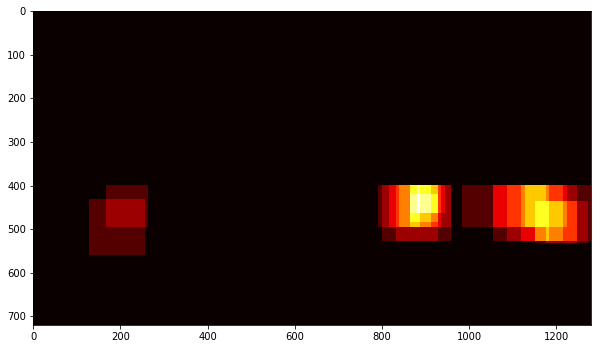

In [19]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

print('...')

### Apply a Threshold to the Heatmap

In [20]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

print('...')

...


...


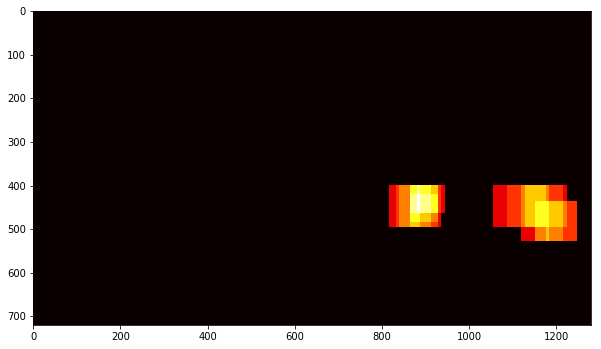

In [21]:
heatmap_img = apply_threshold(heatmap_img, 2)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

print('...')

### Apply SciPy Labels to Heatmap

2 cars found


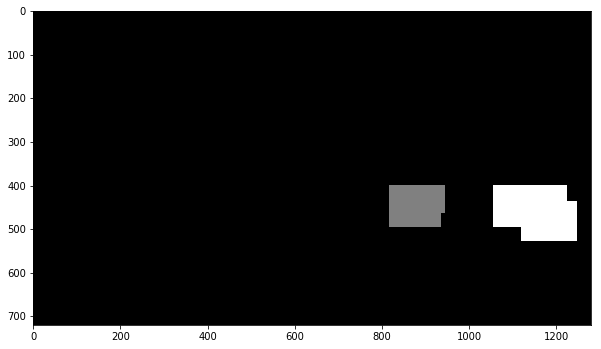

In [22]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

### Draw Bounding Boxes for Lables

...


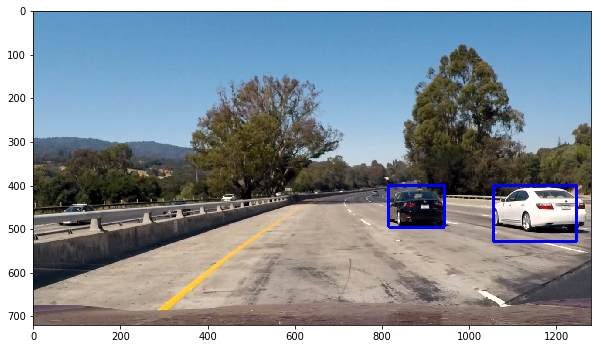

In [23]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
print('...')

### Putting it all together

In [24]:
def vehicle_detection_pipeline(img):
    #Identify all the detection in the image
    detections = combined_detection(img)
    rectangles = [item for sublist in detections for item in sublist] 
    
    #Create a heatmap of detections
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    
    #Aply threshhold on the heatmap to remove false positives
    heatmap_img = apply_threshold(heatmap_img, 2)
    
    #Add label to residual heatmaps after thresholding
    labels = label(heatmap_img)
    
    #Draw bounding boxes covering the thresholded heatmaps
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

Run the pipeline on all the test images.

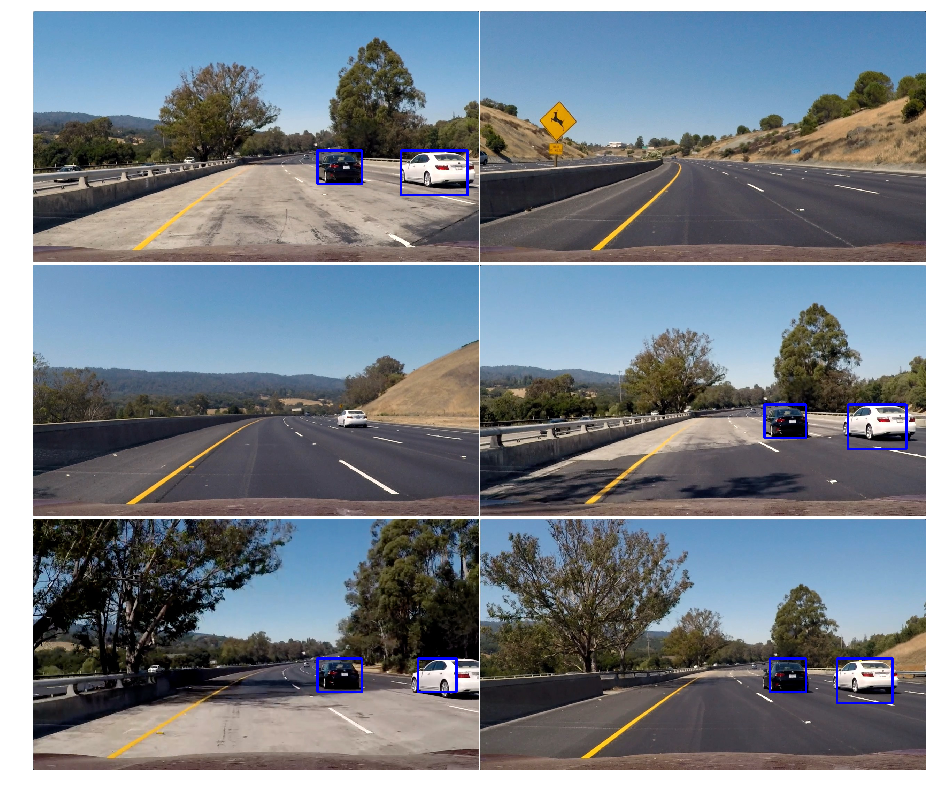

In [25]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(vehicle_detection_pipeline(mpimg.imread(im)))
    axs[i].axis('off')

### Processing a video through the pipeline

In [26]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image( vehicle_detection_pipeline)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:24<00:00,  1.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 23.2 s, sys: 2.02 s, total: 25.2 s
Wall time: 25.5 s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

### Improving video pipeline processing using detection history

In [28]:
# Create a class to store detections in previous frames
class Detection_History():
    def __init__(self):
        # Frame Detection History
        self.detections = [] 
        
    def add_rects(self, rects):
        self.detections.append(rects)
        if len(self.detections) > 15:
            # throw out oldest rectangle set(s)
            self.detections = self.detections[len(self.detections)- 15:]

In [35]:
# Use vehicle detection class to store detection in previous frames and use it create more robust heatmaps

def vehicle_detection_pipeline(img):
    #Identify all the detection in the image
    detections = combined_detection(img)
    rectangles = [item for sublist in detections for item in sublist] 
    
    #Create a heatmap of detections. 
    #Use detection history to create more robust heatmaps
    if len(rectangles) > 0:
        det_history.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det_history.detections:
        heatmap_img = add_heat(heatmap_img, rect_set)
    
    #Aply threshhold on the heatmap to remove false positives
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det_history.detections)//2)
    
    #Add label to residual heatmaps after thresholding
    labels = label(heatmap_img)
    
    #Draw bounding boxes covering the thresholded heatmaps
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

### Run a Video Through the Pipeline (advanced version)

In [36]:
det_history = Detection_History()

test_out_file_2 = 'project_video_out.mp4'
clip_test_2 = VideoFileClip('project_video.mp4')
clip_test_out_2 = clip_test_2.fl_image(vehicle_detection_pipeline)
%time clip_test_out_2.write_videofile(test_out_file_2, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [13:36<00:00,  1.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 12min 44s, sys: 1min 5s, total: 13min 50s
Wall time: 13min 37s


In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file_2))